In [1]:
! pip install pandas==1.1.0 matplotlib==3.5.0

# Time series analysis



In [2]:
# We first import some useful package for the data exploration
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [3]:
accounts = pd.read_csv('../data/accounts.csv', parse_dates=['update_date'], infer_datetime_format=True)
transactions = pd.read_csv('../data/transactions.csv', parse_dates=['date'], infer_datetime_format=True)

### Accounts

We check if there are any duplicates in the balances. We also raise an error if the same account has two different balances for the same day

In [4]:
print(accounts.info())

if len(accounts[accounts.duplicated()]) > 0:
    accounts = accounts.drop_duplicates()
    if len(accounts[accounts['id'].duplicated()]) > 0:
        raise Exception('Account(s) {} has two different balances associated to the same day'.format(accounts['id'].duplicated().to_list()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1254 non-null   int64         
 1   balance      1254 non-null   float64       
 2   update_date  1254 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 29.5 KB
None


The extraction of the balance is the same for all the accounts

In [5]:
#Same final update date
accounts['update_date'].unique()

array(['2021-07-02T00:00:00.000000000'], dtype='datetime64[ns]')

Points outside farther away than 5 std from the mean:
 [-98240.37, 216975.66, 76910.9, 150087.16, 62813.93, 131378.61]


count      1254.000000
mean       2495.186994
std       11853.402866
min      -98240.370000
25%           1.132500
50%          72.065000
75%        1083.257500
max      216975.660000
Name: balance, dtype: float64

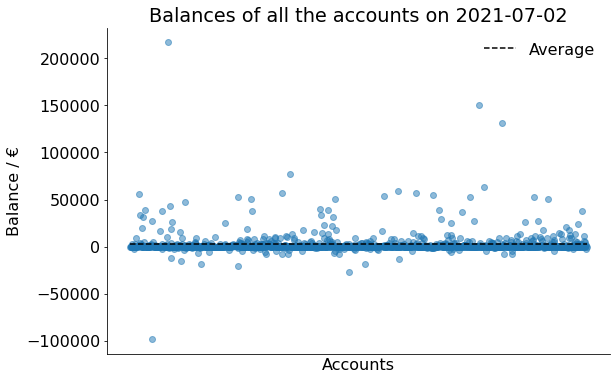

In [6]:
# don't know the data => use all of them even if -100000 seems a little weird

updatedate = str(accounts['update_date'].unique()[0]).split('T')[0]

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(accounts['id'], accounts['balance'], alpha=0.5)
ax.set_title('Balances of all the accounts on {}'.format(updatedate))
ax.set_ylabel('Balance / €')
ax.set_xlabel('Accounts')
ax.set_xticks([])

ax.hlines(xmin=0, xmax=accounts['id'].max(), y=accounts['balance'].mean(), 
          color='k', linestyle='--', label='Average')
ax.legend(frameon=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print('Points outside farther away than 5 std from the mean:\n', 
      accounts[abs(accounts['balance']-accounts['balance'].mean())>5*accounts['balance'].std()]['balance'].to_list())

accounts['balance'].describe()

There are six values very much outside the balance distribution. I am a little suspicious about the value -98240 since usually banks freeze an account before it goes so much down, but since I don't really know the source of the data I decide to keep all of the values.

# Transactions

We first check if there are accounts without transactions or viceversa.

In [41]:
print('Data between {} and {}\n'.format(transactions['date'].max(), transactions['date'].min()))
transactions.info()

Data between 2021-07-01 00:00:00 and 2018-01-02 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518229 entries, 0 to 518228
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   account_id  518229 non-null  int64         
 1   date        518229 non-null  datetime64[ns]
 2   amount      518229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.9 MB


In [39]:

# No missing information on any account
set(transactions['account_id'].unique()) == set(accounts['id'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518229 entries, 0 to 518228
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   account_id  518229 non-null  int64         
 1   date        518229 non-null  datetime64[ns]
 2   amount      518229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.9 MB
None


True

There are several duplicates. If we had the exact time of the transactions we could delete them without problems. Although, since we have only the day, the duplicates could be the results of:

1. An error on the extraction of the data.
2. Two or more transactions with the same value that happened the same day.


In [56]:
print('N duplicated lines: ', len(transactions) - len(transactions.drop_duplicates()))

id_dup = set(transactions[transactions.duplicated()]['account_id'].unique())
id_un = set(transactions['account_id'].unique()).difference(id_dup)
print('There are {} id without any duplicated row'.format(len(id_un)))


day_dup = set(transactions[transactions.duplicated()]['date'].unique())
day_un = set(transactions['date'].unique()).difference(day_dup)
print('There are {} days without any duplicated row'.format(len(day_un)))

if len(transactions[(transactions['account_id'].isin(id_un)) & (transactions['date'].isin(day_dup))])>0 and \
    len(transactions[(transactions['account_id'].isin(id_dup)) & (transactions['date'].isin(day_un))])>0:
    print('The presence of duplicated rows does not seems to be particularly related to day nor account id')

N duplicated lines:  28661
There are 231 id without any duplicated row
There are 311 days without any duplicated row
The presence of duplicated rows does not seems to be particularly related to day nor account id


Without any more information, and given the high number of duplicated rows (more than 28000), for the following I will suppose the duplicated rows are related to an error in their extraction and so I will delete them

In [8]:
# Assume duplicates are not interesting, 
# although they might be two different transactions with the same value happening the same day
transactions = transactions.drop_duplicates()

In [9]:
transactions['amount'].describe()

count    489568.000000
mean          6.060506
std        2014.663220
min     -351200.000000
25%         -59.000000
50%         -16.400000
75%          -1.600000
max      452097.000000
Name: amount, dtype: float64

On average, for each account, we have that if a transaction take place, other two follow.

In [76]:
transactions.groupby(['account_id', 'date']).size().describe()

count    178344.000000
mean          2.905783
std           2.811358
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         199.000000
dtype: float64

There are more than 10000 transactions with an amount equal to 0.0. It would be interesting to know if they are related to authorizations (and might then be a signal for a future transactions).

In [74]:
ac_day_zero = transactions[transactions['amount']==0][['account_id', 'date']].drop_duplicates().values


,account_id,date,amount
0,0,2020-10-16,200.00
2,0,2020-10-16,200.00
6,0,2020-10-16,3000.00
15,0,2020-10-19,100.00
26,0,2020-10-23,707.00
...,...,...,...
515871,1249,2020-08-07,2000.00
515890,1249,2020-09-04,3273.60
515935,1249,2020-12-08,3026.80
515982,1249,2021-03-09,1153.92


In [77]:
transactions.groupby('account_id')['amount'].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,1254.000000,1254.000000,1247.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,413.260766,22.063970,1167.299076,-5428.472783,-169.183439,-27.270734,78.892406,8597.180343
std,472.500559,228.500449,2391.955239,14778.339899,442.958114,198.073296,452.144278,20997.583702
min,1.000000,-1075.123125,0.000000,-351200.000000,-8000.000000,-1300.000000,-833.330000,-12.230000
25%,77.250000,-0.146414,261.653041,-5000.000000,-122.268750,-29.637500,-6.446250,1500.000000
50%,249.000000,0.258670,550.027744,-2500.000000,-55.188750,-16.142500,-1.882500,3890.000000
75%,593.750000,3.585337,1261.201769,-1000.000000,-31.875000,-9.002500,10.950000,9962.077500
max,3427.000000,4662.500000,50020.867583,720.000000,1800.000000,3700.000000,6655.000000,452097.000000


# Data preparation

In [15]:
transactions = transactions.sort_values(by=['account_id', 'date'], ascending=[True, False]).reset_index(drop=True)
accounts = accounts.sort_values(by=['id'], ascending=True).reset_index(drop=True)

In [17]:
trans = transactions.copy(deep=True)
transactions

,account_id,date,amount
0,0,2021-06-30,380.00
1,0,2021-06-30,0.00
2,0,2021-06-30,-371.90
3,0,2021-06-29,0.00
4,0,2021-06-28,999.00
...,...,...,...
489563,1253,2020-07-01,-67.00
489564,1253,2020-07-01,-7.10
489565,1253,2020-06-30,-52.56
489566,1253,2020-06-30,-60.00


In [27]:

transactions.loc[transactions[transactions['account_id'].diff() != 0].index, 'balance'] = accounts['balance']
transactions.loc[transactions['balance'].isnull(), 'balance'] = -transactions['amount'].shift()

transactions.loc[:, 'balance'] = transactions.groupby('account_id')['balance'].cumsum()

transactions.loc[:, 'balance_start'] = transactions.groupby('account_id')['balance'].shift(-1)

In [28]:
transactions

,account_id,date,amount,balance,balance_start
0,0,2021-06-30,380.00,13.63,-352.74
1,0,2021-06-30,0.00,-352.74,-719.11
2,0,2021-06-30,-371.90,-719.11,-713.58
3,0,2021-06-29,0.00,-713.58,-708.05
4,0,2021-06-28,999.00,-708.05,-1701.52
...,...,...,...,...,...
489563,1253,2020-07-01,-67.00,901.28,1156.24
489564,1253,2020-07-01,-7.10,1156.24,1418.30
489565,1253,2020-06-30,-52.56,1418.30,1732.92
489566,1253,2020-06-30,-60.00,1732.92,2107.54
